In [10]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import vcf
import os
import subprocess


## <div align="center"> Low Frequency Variant (LFV) Extractor </div>
### Inputs:
* filename: a vcf file
* extract_type: a string that is either 'biallelic' or 'multiallelic'

### Outputs
* lfv_list: a list of tuples with low frequency variants in the form (position, variant, frequency)

<div align="center"> *If one position has multiple variants, it will be represented in a tuple for each low frequency variant* </div>

In [11]:
def lfv_extractor(filename, extract_type):
    if extract_type != 'multiallelic' and extract_type != 'biallelic':
        return('Please enter valid extract type.')
    lfv_list = [filename]
    vcf_read = vcf.Reader(open(filename, 'r'))
    previous_previous = (None, None, None)
    previous = (None, None, None)
    for record in vcf_read:
        af = None
        variant = None
        #removes multiallelic variants at a single position
        if previous == record.POS and extract_type == 'biallelic':
            lfv_list.pop()
            previous = record.POS
            break
        #handles case of 2 variants
        if previous[0] == record.POS and previous_previous[0] != record.POS and extract_type == 'multiallelic':
            if previous[1] == record.REF:
                new_af = previous[2] - record.INFO['AF']
                previous = (previous[0], previous[1], new_af)
                lfv_list.pop()
                lfv_list.append(previous)
                lfv_list.append((record.POS, record.ALT, record.INFO['AF']))
                previous_previous = previous
                previous = (record.POS, record.ALT, record.INFO['AF'])
            elif record.INFO['AF'] > 0.5:
                af = 1 - record.INFO['AF'] - previous[2]
                lfv_list.append((record.POS, record.REF, af))
                previous_previous = previous
                previous = (record.POS, record.REF, af)
            else: 
                lfv_list.append((record.POS, record.ALT, record.INFO['AF']))
                previous_previous = previous
                previous = (record.POS, record.ALT, record.INFO['AF'])
            break
        if previous[0] == record.POS and previous_previous[0] == record.POS and extract_type == 'multiallelic':
            if previous_previous[1] == record.REF:
                previous_previous[2] = previous_previous[2] - record.INFO['AF']
                lfv_list.pop()
                lfv_list.pop()
                lfv_list.append(previous_previous)
                lfv_list.append(previous)
                lfv_list.append((record.POS, record.ALT, record.INFO['AF']))
                previous_previous = previous
                previous = (record.POS, record.ALT, record.INFO['AF'])
            elif previous[1] == record.REF:
                new_af = previous[2] - record.INFO['AF']
                previous = (previous[0], previous[1], new_af)
                lfv_list.pop()
                lfv_list.append(previous)
                lfv_list.append((record.POS, record.ALT, record.INFO['AF']))
                previous_previous = previous
                previous = (record.POS, record.REF, record.INFO['AF'])
            elif record.INFO['AF'] > 0.5:
                af = 1 - record.INFO['AF'] - previous[2] - previous_previous[2]
                lfv_list.append((record.POS, record.REF, af))
                previous_previous = previous
                previous = (record.POS, record.REF, af)
            else:
                lfv_list.append(record.POS, record.ALT, record.INFO['AF'])
                previous_previous = previous
                previous = (record.POS, record.ALT, record.INFO['AF'])
            break
        #handles cases where the current and previous position are different
        elif record.INFO['AF'] > 0.5:
            af = 1 - record.INFO['AF']
            variant = record.REF
        elif record.INFO['AF'] < 0.5:
            af = record.INFO['AF']
            variant = record.ALT
        lfv_list.append((record.POS, variant, af))
        previous_previous= previous
        previous = (record.POS, variant, af)
    return lfv_list
        

 ## <div align="center"> Shared Variants </div>
### Inputs:
* **lfv_dict1:** a list of tuples containing low frequency variants of a vcf in the form (position, variant, frequency)
* **lfv_dict2:** a list of tuples containing low frequency variants of a vcf in the form (position, variant, frequency)

### Outputs:
* **shared:** a list of tuples with all of the shared variants between the two input files in the form (position, variant, frequency1, frequency2)

In [12]:
def shared_variants(lfv_list1, lfv_list2):
    #adds filenames as first two elements of shared
    shared = [lfv_list1[0], lfv_list2[0]]
    #get list of shared variants
    for num1 in range(1, len(lfv_list1) - 1):
        for num2 in range(1, len(lfv_list2) - 1):
            #add to list of shared variants
            if lfv_list1[num1][0] == lfv_list2[num2][0] and lfv_list1[num1][1] == lfv_list2[num2][1]:
                shared.append((lfv_list1[num1][0], lfv_list1[num1][1], lfv_list1[num1][2], lfv_list2[num2][2]))
    return shared

 ## <div align="center"> Bar Plot Input </div>
### Inputs:
* **donor:** a list of tuples containing low frequency variants of the donor in the form (position, variant, frequency)
* **recipient:** a list of tuples containing low frequency variants of the recipient in the form (position, variant, frequency)

### Outputs:
* **bar_input:** a list of tuples with all of the donor variants and their frequencies in the recipient in the form (position, variant, donor frequency, recipient frequency)

In [13]:
def bar_plot_input(donor, recipient):
    bar_input = [donor[0], recipient[0]]
    for num1 in range(1, len(donor) - 1):
        recipient_frequency = 0
        for num2 in range(1, len(recipient) - 1):
            if donor[num1][0] == recipient[num2][0] and donor[num1][1] == recipient[num2][1]:
                recipient_frequency = recipient[num2][2]
        bar_input.append((donor[num1][0], donor[num1][1], donor[num1][2], recipient_frequency))
    return bar_input

## <div align="center"> Bar Plot </div> 
### Inputs:
* **bar_plot_input:** a list of tuples containing low frequency variants of the donor in the form (position, variant, frequency)

### Outputs:
* **bar plot:** a bar plot displaying the frequency of donor variants in the recipient

In [14]:
def bar_plot(bar_plot_input):
    
    filename1 = bar_plot_input[0]
    filename2 = bar_plot_input[1]

    positions = []
    frequency1 = []
    frequency2 = []
    allele = []

    for num in range(2, len(bar_plot_input)):
        positions.append((bar_plot_input[num][0], bar_plot_input[num][1]))
        allele.append(bar_plot_input[num][1])
        frequency1.append(round(bar_plot_input[num][2], 2))
        frequency2.append(round(bar_plot_input[num][3], 2))

    x = np.arange(len(positions)) #label location
    width = 0.25 #bar width

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, frequency1, width, label=filename1, color='#7f6d5f')
    rects2 = ax.bar(x + width/2, frequency2, width, label=filename2, color='#557f2d')

    ax.set_ylabel('Allele Frequency')
    ax.set_xlabel('Position & Allele')
    ax.set_title('Low Frequency Variants')
    ax.set_xticks(x)
    ax.set_xticklabels(positions)
    ax.legend()

    plt.xticks(rotation=60, size=9)
    plt.yticks(size=9)
    plt.legend(fontsize=9)

    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height), xy=(rect.get_x() + rect.get_width() / 2, height), xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')
    
    autolabel(rects1)
    autolabel(rects2)

    fig.tight_layout()
    plt.show()
    

 ## <div align="center"> Bottleneck Input </div>
### Inputs:
* **bb_input:** a list of tuples with all of the donor variants and their frequencies in the recipient in the form (position, variant, donor frequency, recipient frequency)

### Outputs:
* **bottleneck.txt:** creates/updates a text file in the form of a BB_bottleneck input file

In [15]:
def bottleneck_input(bb_input):

    bb = open("bottleneck.txt", "w+")
    for num in range(2, len(bb_input) - 1):
        bb.write(str(bb_input[num][2]) + "\t" + str(bb_input[num][3]) + "\n")
    bb.close()

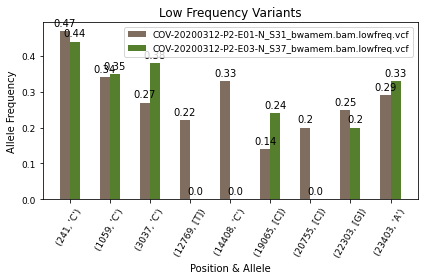

In [16]:
file1 = lfv_extractor('COV-20200312-P2-E01-N_S31_bwamem.bam.lowfreq.vcf', 'multiallelic')
file2 = lfv_extractor('COV-20200312-P2-E03-N_S37_bwamem.bam.lowfreq.vcf', 'multiallelic')
prac = (bar_plot_input(file1, file2))
bar_plot(prac)
bottleneck_input(prac)


## <div align="center"> BB_bottleneck Output </div>

<div align="center"> Runs BB_bottleneck software on bottleneck.txt  </div>

In [17]:
!Rscript Bottleneck_size_estimation_approx.r --file "bottleneck.txt" --plot_bool TRUE --var_calling_threshold 0.03 --Nb_min 1 --Nb_max 200 --confidence_level .95


[1] "Bottleneck size"
[1] 6
[1] "confidence interval left bound"
[1] 3
[1] "confidence interval right bound"
[1] 13


-- Attaching packages --------------------------------------- tidyverse 1.3.0 --
v ggplot2 3.3.1     v purrr   0.3.4
v tibble  3.0.1     v dplyr   1.0.0
v tidyr   1.1.0     v stringr 1.4.0
v readr   1.3.1     v forcats 0.5.0
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
Saving 7 x 7 in image


## <div align="center"> RAxML </div>

<div align="center"> Runs RAxML on ____ </div>

In [46]:
!raxmlHPC -s\Users\maryb\Downloads\COVID\parsnp.mfa -n_raxml -m GTRGAMMA -p 20


RAxML can't, parse the alignment file as phylip file 
it will now try to parse it as FASTA file



IMPORTANT WARNING: Sequences COV-20200312-P3-C02-N_S49_bwamem.bam.lowfreq_0.02.fasta and ENV-235057491_S85_bwamem.bam.lowfreq_0.02.fasta are exactly identical


IMPORTANT WARNING: Sequences COV-20200316-P11-E02-N_bwamem.bam.lowfreq_0.02.fasta and COV-20200316-P12-E03-N_bwamem.bam.lowfreq_0.02.fasta are exactly identical


IMPORTANT WARNING: Sequences COV-20200316-P12-A01-CP_bwamem.bam.lowfreq_0.02_1.fasta and COV-20200316-P12-A01-CP_bwamem.bam.lowfreq_0.02_2.fasta are exactly identical


IMPORTANT WARNING: Sequences COV-20200316-P12-A01-CP_bwamem.bam.lowfreq_0.02_1.fasta and COV-20200316-P12-A01-CP_bwamem.bam.lowfreq_0.02_0.fasta are exactly identical


IMPORTANT WARNING: Sequences COV-20200312-P2-H03-P_S7_bwamem.bam.lowfreq_0.02_1.fasta and COV-20200312-P2-H03-P_S7_bwamem.bam.lowfreq_0.02_2.fasta are exactly identical


IMPORTANT WARNING: Sequences COV-20200312-P2-H03-P_S7_bwamem.bam.lo